# Анализ чувствительности: общие идеи

## Постановка задачи

Фабрика производит три вида продукции: П1, П2 и П3. 

Известна цена на продукцию для распространителей и приблизительный спрос на каждый из видов продукции в неделю (см. Таблицу 1). 

Процессы производства продукции разных видов имеют отличия. На фабрике есть три цеха: Ц1, Ц2 и Ц3. Для производства продукции П1 необходимы только технологические операции, производимые цехом Ц1, для П2 – Ц1 и Ц3, для производства П3 – необходима полная технологическая цепочка, включающая обработку во всех трех цехах. 

В цехах Ц1 и Ц2 продукция разных видов обрабатывается одинаково, и известна общая производительность этих цехов в единицах обработанной продукции в неделю, то в цехе Ц3 предполагается ручная обработка (см. Таблицу 2). 

Из всех видов материалов, используемых при производстве продукции, ограниченным является только один, поставки его в неделю и потребности для каждого из видов продукции приведены в таблице 3. 

Необходимо составить производственный план на неделю, максимизирующий выручку от реализации продукции.

Таблица 1 - Характеристики продукции

| Вид продукции | Цена, руб. | Спрос, шт. в неделю (мин./баз./макс.) |
|---------------|------------|---------------------------------------|
| П1            | 1200       | 20/25/35                              |
| П2            | 2500       | 10/20/30                              |
| П3            | 1400       | 20/25/30                              |

Таблица 2 - Производительность цехов

| Ц1, шт. в неделю | Ц2, шт. в неделю | Ц3, часов (П2/П3/Общий фонд) |
|------------------|------------------|------------------------------|
| 40               | 20               | 8/2/80                       |

Таблица 3 - Материалы

| Поставки в неделю, кг | На ед. продукта  П1, кг | На ед. продукта  П2, кг | На ед. продукта  П3, кг |
|-----------------------|-------------------------|-------------------------|-------------------------|
| 50                    | 0,8                     | 0,6                     | 0,7                     |

(для генерации таблиц в Markdown можно использовать, например: https://www.tablesgenerator.com/markdown_tables) 

## Формальная постановка задачи

Пусть $x_i$ - количество единиц продукции i-того вида, которое необходимо произвести за неделю ($i \in {1, 2, 3}$). 

Целевая функция и ограничения:
$$
1200x_1 + 2500x_2 + 1400x_3 \rightarrow max \\
x_1 + x_2 + x_3 \leq 40 \\
x_3 \leq 20 \\
8x_2 + 2x_3 \leq 80 \\
x_1 \leq 25 \\
x_2 \leq 20 \\
x_3 \leq 25 \\
0.8x_1 + 0.6x_2 + 0.7x_3 \leq 50 \\
x_{1,2,3} \geq 0
$$

Табличное представление:

|  * | x1   | x2   | x3   | Неравенство | b   |
|----|------|------|------|-------------|-----|
| с  | 1200 | 2500 | 1400 | -           | max |
| y1 | 1    | 1    | 1    | <=          | 40  |
| y2 | 0    | 0    | 1    | <=          | 20  |
| y3 | 0    | 8    | 2    | <=          | 80  |
| y4 | 1    | 0    | 0    | <=          | 25  |
| y5 | 0    | 1    | 0    | <=          | 20  |
| y6 | 0    | 0    | 1    | <=          | 25  |
| y7 | 0,8  | 0,6  | 0,7  | <=          | 50  |



In [2]:
from cvxopt import matrix, solvers

def solve(demand1, demand2, demand3):
    c = matrix([-1200., -2500., -1400.])       
    G = matrix([[  1,   1,   1],
                [  0,   0,   1],
                [  0,   8,   2],
                [  1,   0,   0],
                [  0,   1,   0],
                [  0,   0,   1],
                [0.8, 0.6, 0.7],
                [ -1,   0,   0],
                [  0,  -1,   0],
                [  0,   0,  -1]])
    h = matrix([40, 20, 80, float(demand1), float(demand2), float(demand3), 50, 0, 0, 0], tc='d')
    solution = solvers.lp(c, G.T, h, solver='glpk')
    return (solution['status'] == 'optimal', -solution['primal objective']-55000, solution['x'], solution)

# Решение задачи со средними значениями параметров
solution = solve(25, 20, 25)

print('Status:', solution[0])
print('Objective:', solution[1])
print('x = \n', solution[2])

Status: True
Objective: 5166.6666666666715
x = 
 [ 2.50e+01]
[ 8.33e+00]
[ 6.67e+00]



# Анализ чувствительности для одного параметра


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt    # pyplot используется для настройки внешнего вида графиков

# Чтобы графики сразу отображались в блокноте
%matplotlib inline

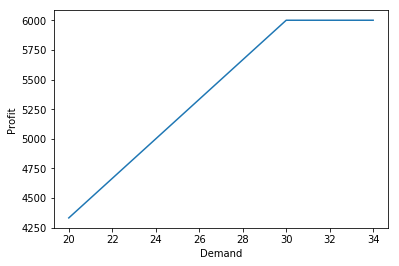

In [4]:
# Проанализируем влияние спроса на продукт П1 на недельную чистую прибыль

x = list(range(20, 35))
fig_df = pd.DataFrame({'Demand': x,
                       'Profit': list(map(lambda x: solve(x, 20, 25)[1], x))})
sns.lineplot(data=fig_df, x='Demand', y='Profit')


## Диаграмма торнадо

Построим своеобразный "заменитель" диаграммы торнадо с помощью boxplot. Выглядит это не очень красиво, но основные функции выполняет.


  Parameter       Profit
0   demand1  4333.333333
1   demand2  5166.666667
2   demand3  5166.666667
3   demand1  6000.000000
4   demand2  5166.666667
5   demand3  5166.666667


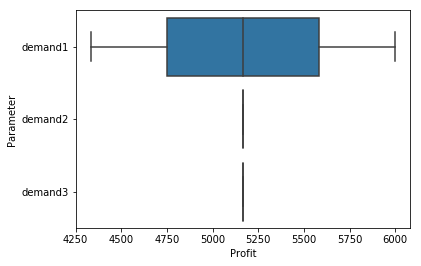

In [5]:
# Диапазоны изменения исследуемых параметров: минимальное значение, базовое, максимальное
ranges = {
   'demand1': (20, 25, 35),
   'demand2': (10, 20, 30), 
   'demand3': (20, 25, 30),
}

variables = ['demand1', 'demand2', 'demand3']
# Таблица с базовыми значениями всех исследуемых параметров
base_args = {k : ranges[k][1] for k in variables}
min_val = []
max_val = []
for variable in variables:
    args = base_args.copy()
    # Изменим значение параметра `variable` на минимальное
    args[variable] = ranges[variable][0]
    min_val.append(solve(**args)[1])
    args = base_args.copy()
    # Изменим значение параметра `variable` на максимальное
    args[variable] = ranges[variable][2]
    max_val.append(solve(**args)[1])

plot_df = pd.DataFrame({'Parameter': variables + variables, 
                        'Profit': min_val + max_val})

print(plot_df)
sns.boxplot(data=plot_df, x='Profit', y='Parameter')                        
                        

# Анализ чувствительности для двух параметров

Text(0, 0.5, 'Profit')

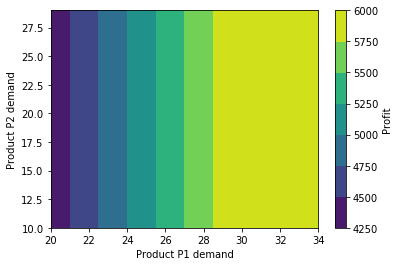

In [34]:
import numpy as np

d1vals = np.arange(ranges['demand1'][0], ranges['demand1'][2], 1)
d2vals = np.arange(ranges['demand2'][0], ranges['demand2'][2], 1)
xx, yy = np.meshgrid(d1vals, d2vals)

cs = plt.contourf(d1vals, 
                  d2vals, 
                  np.vectorize(lambda x, y, z: solve(x,y,z)[1])(xx,yy,ranges['demand3'][1])
                 # , levels=[5000, 50000]
                 )
plt.xlabel('Product P1 demand')
plt.ylabel('Product P2 demand')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel('Profit')
